In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)


2.7.0


In [ ]:
# untar
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [ ]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())

In [ ]:
# We trained the initial model upto 300 epochs to get a training accuracy around 97%

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=32, epochs=300, 
                    validation_data=(val_images, val_labels))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


90/90 [==============================] - 4s 30ms/step - loss: 0.0792 - accuracy: 0.9741 - val_loss: 1.0406 - val_accuracy: 0.7632


In this method I have implemented layer by layer freezing of pruned weights and then retraining the rest of the weights.

In [ ]:
# List to store the sparsity and accuracy after retraining the model with pruning
spar=[]
accu=[]

In [ ]:
k_99 = np.arange(100)       # Creates an array of equally spaced numbers upto 99
k_60 = np.arange(61)        # Creates an array of equally spaced numbers upto 60 
lay = [8,9]                 # Weights to be pruned
model.layers[10].trainable=False # Layers corresponding to the weights
model.layers[11].trainable=False
model.layers[12].trainable=False
model.layers[13].trainable=False
model.layers[14].trainable=False
model.layers[15].trainable=False

for i in k_99:
  if i<80:
    tr_weights=np.copy(model.get_weights())
    for j in lay:
      weights = model.get_weights()
      thres = np.percentile(np.absolute(weights[j]),i)
      tr = np.absolute(weights[j])>thres
      tr_weights[j] = np.multiply(weights[j],tr)
    model.set_weights(tr_weights)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=120, epochs=50, 
                        validation_data=(val_images, val_labels))
    spar.append(np.sum(np.hstack([k.flatten() for k in tr_weights])==0)/np.shape(np.hstack([k.flatten() for k in tr_weights]))[0])
    result = model.evaluate(val_images,val_labels,batch_size=128)
    accu.append(result[1])
  else:
    tr_weights=np.copy(model.get_weights())
    for j in lay:
      weights = model.get_weights()
      thres = np.percentile(np.absolute(weights[j]),i)
      tr = np.absolute(weights[j])>thres
      tr_weights[j] = np.multiply(weights[j],tr)
    model.set_weights(tr_weights)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=32, epochs=100, 
                        validation_data=(val_images, val_labels))
    spar.append(np.sum(np.hstack([k.flatten() for k in tr_weights])==0)/np.shape(np.hstack([k.flatten() for k in tr_weights]))[0])
    result = model.evaluate(val_images,val_labels,batch_size=128)
    accu.append(result[1])

In [ ]:
lay = [6,7]
model.layers[8].trainable=False #6,7
model.layers[9].trainable=False
for i in k_99:
  tr_weights=np.copy(model.get_weights())
  for j in lay:
    weights = model.get_weights()
    thres = np.percentile(np.absolute(weights[j]),i)
    tr = np.absolute(weights[j])>thres
    tr_weights[j] = np.multiply(weights[j],tr)
  model.set_weights(tr_weights)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
  history = model.fit(train_images, train_labels, batch_size=32, epochs=150, 
                        validation_data=(val_images, val_labels))
  spar.append(np.sum(np.hstack([k.flatten() for k in tr_weights])==0)/np.shape(np.hstack([k.flatten() for k in tr_weights]))[0])
  result = model.evaluate(val_images,val_labels,batch_size=128)
  accu.append(result[1])

In [ ]:
lay = [4,5]
model.layers[4].trainable=False#4,5
model.layers[5].trainable=False
model.layers[6].trainable=False
model.layers[7].trainable=False
for i in k_60:
  tr_weights=np.copy(model.get_weights())
  for j in lay:
    weights = model.get_weights()
    thres = np.percentile(np.absolute(weights[j]),i)
    tr = np.absolute(weights[j])>thres
    tr_weights[j] = np.multiply(weights[j],tr)
  model.set_weights(tr_weights)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
  history = model.fit(train_images, train_labels, batch_size=32, epochs=2000, 
                        validation_data=(val_images, val_labels))
  spar.append(np.sum(np.hstack([k.flatten() for k in tr_weights])==0)/np.shape(np.hstack([k.flatten() for k in tr_weights]))[0])
  result = model.evaluate(val_images,val_labels,batch_size=128)
  accu.append(result[1])

Text(0, 0.5, 'Accuracy')

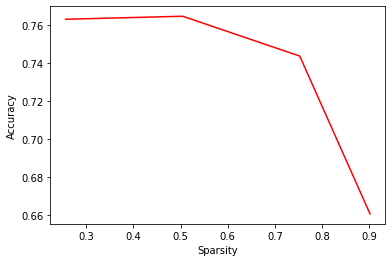

In [ ]:
plt.plot(spar,accu,color='red')
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")

In [ ]:
from google.colab import files
sparse_model_weight.save_weights("my_model_weights.h5")
files.download("my_model_weights.h5")